In [1]:
import numpy as np
import matplotlib.pyplot as plt
import copy
from scipy import optimize

In [2]:
"""
1 Volatility of the O&M cost coefficient: sigma_H = 0.25
2 Volatility of the energy saving amount coefficient: sigma_K = 0.01
3 Energy price drift effect: alpha_E = 0.0523
4 Energy price volatility effect: sigma_E = 0.0856
5 O&M trend index: delta = 1.025
6 Initial value of the O&M cost coefficient: H0 = 0.0036
7 Initial value of the energy saving amount coefficient: K0 = 0.0043
8 Initial value of the energy price: PE0 = 22.82
9 Economic lifetime of the energy efficiency system: N = 25
10 Capital cost of the energy efficiency investment: IC = 20668991
11 Annual energy cost savings guarantee: G = 3000000
12 Owners’ expected revenue share within the guarantee: alpha = 0.05
13 Owners’ excess revenue share beyond the guarantee: beta = 0.2
14 Owners’ expected rate of return: r0 = 0.031
15 Renters’ expected rate of return: rR = 0.031
16 Project interest rate: rP = 0.031
17 ESCOs’ expected rate of return: rE = 0.06
18 Owners’ expected revenue share with renters: theta = 1
19 Maximum renters’ rebound effect: phi = 0.15
20 Risk attitude of renters: rho = −20
"""

'\n1 Volatility of the O&M cost coefficient: sigma_H = 0.25\n2 Volatility of the energy saving amount coefficient: sigma_K = 0.01\n3 Energy price drift effect: alpha_E = 0.0523\n4 Energy price volatility effect: sigma_E = 0.0856\n5 O&M trend index: delta = 1.025\n6 Initial value of the O&M cost coefficient: H0 = 0.0036\n7 Initial value of the energy saving amount coefficient: K0 = 0.0043\n8 Initial value of the energy price: PE0 = 22.82\n9 Economic lifetime of the energy efficiency system: N = 25\n10 Capital cost of the energy efficiency investment: IC = 20668991\n11 Annual energy cost savings guarantee: G = 3000000\n12 Owners’ expected revenue share within the guarantee: alpha = 0.05\n13 Owners’ excess revenue share beyond the guarantee: beta = 0.2\n14 Owners’ expected rate of return: r0 = 0.031\n15 Renters’ expected rate of return: rR = 0.031\n16 Project interest rate: rP = 0.031\n17 ESCOs’ expected rate of return: rE = 0.06\n18 Owners’ expected revenue share with renters: theta = 1\

In [3]:
params = {
    'IC': 6170000,
    'G': 431900, 
    'theta': 0.8,
    'n': 15,
    'phi': 0.5,
    'sigma_H': 0.25, 
    'sigma_K': 0.01, 
    'alpha_E': 0.0523,
    'sigma_E': 0.0856,
    'delta': 1.025,
    'H0': 0.0036,
    'K0': 0.43,
    'PE0': 0.24,
    'N': 25,
    'alpha': 0.05,
    'beta': 0.2,
    'r0': 0.031,
    'rR': 0.031,
    'rP': 0.031,
    'rE': 0.06,
    'rho': -20,
    'eps_H': 0.01,
    'eps_P': 0.01,
    'eps_K': 0.01
    }

In [4]:
def evaluate_KPIs(params):
    IC = params['IC']
    sigma_H = params['sigma_H']
    sigma_K = params['sigma_K']
    alpha_E = params['alpha_E']
    sigma_E = params['sigma_E']
    delta = params['delta']
    H0 = params['H0']
    K0 = params['K0']
    PE0 = params['PE0']
    N = params['N']
    alpha = params['alpha']
    beta = params['beta']
    r0 = params['r0']
    rR = params['rR']
    rP = params['rP']
    rE = params['rE']
    rho = params['rho']
    eps_H = params['eps_H']
    eps_P = params['eps_P']
    eps_K = params['eps_K']
    phi = params['phi']
    theta = params['theta']
    n = params['n']
    G = params['G']

    t = np.arange(N+1)

    H = IC*H0*np.exp((-np.square(sigma_H)*t/2)+(sigma_H*eps_H*np.sqrt(t)))
    I_OM = (1/delta)*H

    I = np.zeros(N+1)
    I = copy.deepcopy(I_OM)
    I[0] = IC    

    PE = PE0*np.exp((alpha_E-(np.square(sigma_E)/2))*t+sigma_E*eps_P*np.sqrt(t))
    K = IC*K0*np.exp((-np.square(sigma_K)*t/2)+(sigma_K*eps_K*np.sqrt(t)))
    f = np.log(N + 1 - t)/np.log(N)

    b = phi/(1 - np.exp(-100/rho))
    a = 1 - b
    Re = a + b*np.exp(-(200*theta-100)/rho)
    Q = f*Re*K

    R_hat = Q*PE
    R_hat[0] = 0
    R = R_hat

    R_E = np.zeros(N+1)
    for i in np.arange(1, n+1):
        R_E[i] = R[i] - alpha*G - np.max([0, beta*(R[i]-G)]) 

    R_R = np.zeros(N+1)
    for i in np.arange(1, N+1):
        R_R[i] = (1-theta)*(alpha*G + np.max([0, beta*(R[i]-G)]))
    
    R_O = np.zeros(N+1)
    for i in np.arange(1, n+1):
        R_O[i] = theta*(alpha*G + np.max([0, beta*(R[i]-G)]))
    R_O[(n+1):(N+1)] = R[(n+1):(N+1)] - R_R[(n+1):(N+1)]  

    NPVR = np.zeros(N+1)
    NPVR[0] = 0
    for i in np.arange(1, N+1):
        NPVR[i] = R_R[i]/pow((1+rR), i)
    NPV_R = sum(NPVR)

    NPV0 = np.zeros(N+1)
    NPV0[0] = 0
    for i in np.arange(1, N+1):
        NPV0[i] = (R_O[i] - I_OM[i])/pow((1+r0), i)
    NPV_0 = sum(NPV0)

    NPVE = np.zeros(n+1)
    NPVE[0] = -IC
    for i in np.arange(1, n+1):
        NPVE[i] = (R_E[i] - I_OM[i])/pow((1+rE), i)    
    NPV_E = sum(NPVE)

    NPVP = np.zeros(N+1)
    for i in np.arange(1, N+1):
        NPVP[i] = (R[i] - I[i])/pow((1+rP), i)    
    NPV_P = sum(NPVP)

    return NPV_R, NPV_0, NPV_E, NPV_P, R, R_E, R_R, R_O, PE, f, Re, K, Q, R

In [5]:
def simulation (params, theta_min, theta_max, N):
    NPV_R = list()
    NPV_0 = list()
    NPV_E = list()
    NPV_P = list()
    duration = list()
    thetas = list()
    vec_Re = list()
    delta_theta = (theta_max - theta_min)/N
    for i in range(N):
        theta = theta_min + delta_theta*i
        thetas.append(theta)
        params['theta'] = theta
        NPVR, NPV0, NPVE, NPVP, R, R_E, R_R, R_O, PE, f, Re, K, Q, R = evaluate_KPIs(params)
        NPV_R.append(NPVR/1e6)
        NPV_0.append(NPV0/1e6)
        NPV_E.append(NPVE/1e6)
        NPV_P.append(NPVP)
        duration.append(params['n'])
        vec_Re.append(Re)
    theta_opt = theta_min + delta_theta*NPV_0.index(max(NPV_0))
    return NPV_R, NPV_0, NPV_E, NPV_P, R, R_E, R_R, R_O, PE, f, Re, K, Q, R, vec_Re, thetas, theta_opt

NPV_R =  310673.4709429192
NPV_0 =  4459648.155440708
NPV_E =  204523.2315408371
NPV_P =  12865432.213140083
f =  [1.0121846  1.         0.98731793 0.97409605 0.96028633 0.94583407
 0.93067656 0.9147414  0.89794447 0.88018721 0.86135312 0.8413031
 0.81986926 0.79684632 0.77197966 0.74494805 0.71533828 0.68260619
 0.64601484 0.60453098 0.55664138 0.5        0.43067656 0.3413031
 0.21533828 0.        ]


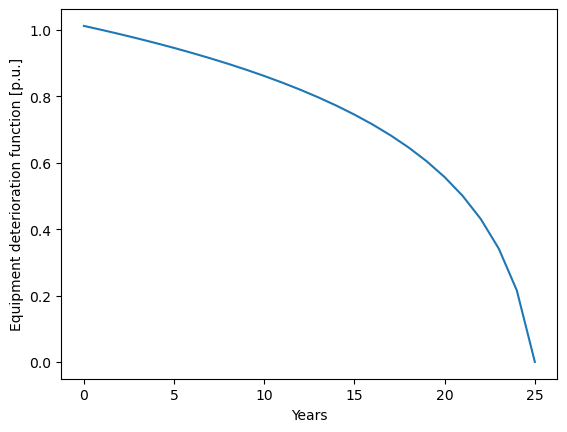

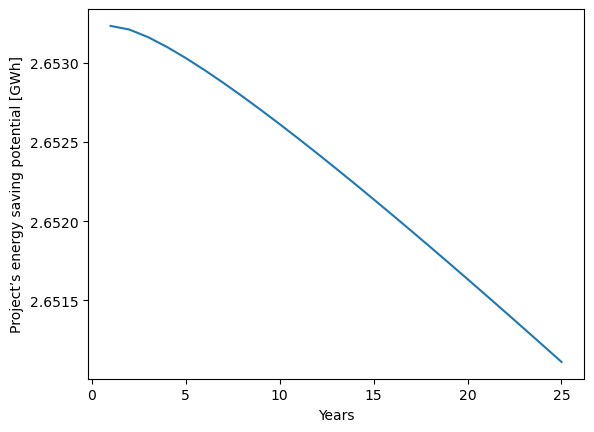

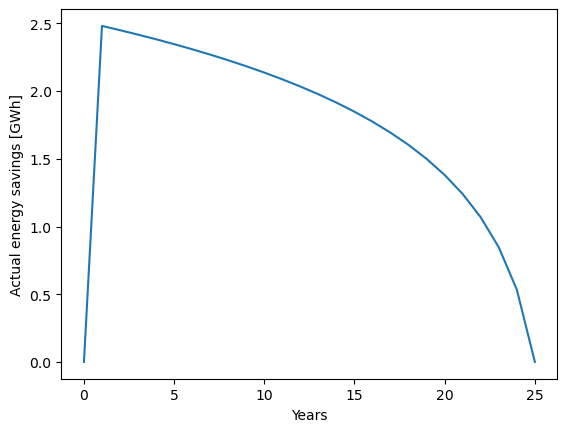

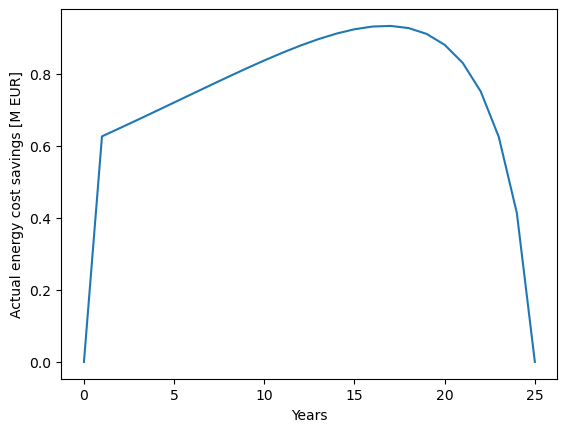

In [6]:
# Test evaluation of KPIs function
NPV_R, NPV_0, NPV_E, NPV_P, R, R_E, R_R, R_O, PE, f, Re, K, Q, R = evaluate_KPIs(params)

print("NPV_R = ", NPV_R)
print("NPV_0 = ", NPV_0)
print("NPV_E = ", NPV_E)
print("NPV_P = ", NPV_P)

print("f = ", f)

# The deterio-ration of the facilities and/or equipment across the project lifetime
t = np.arange(26)
plt.plot(t, f)
plt.xlabel('Years')
plt.ylabel('Equipment deterioration function [p.u.]')
plt.show()

# Project energy savings potential
plt.plot(t[1:], K[1:]/1e6)
plt.xlabel('Years')
plt.ylabel('Project’s energy saving potential [GWh]')
plt.show()

# Actual energy savings
Q[0] = 0
plt.plot(t, Q/1e6)
plt.xlabel('Years')
plt.ylabel('Actual energy savings [GWh]')
plt.show()

# Actual energy cost savings
plt.plot(t, R/1e6)
plt.xlabel('Years')
plt.ylabel('Actual energy cost savings [M EUR]')
plt.show()

In [7]:
N = 49
theta_min = 0.5 
theta_max = 0.99
delta_theta = (theta_max - theta_min)/N

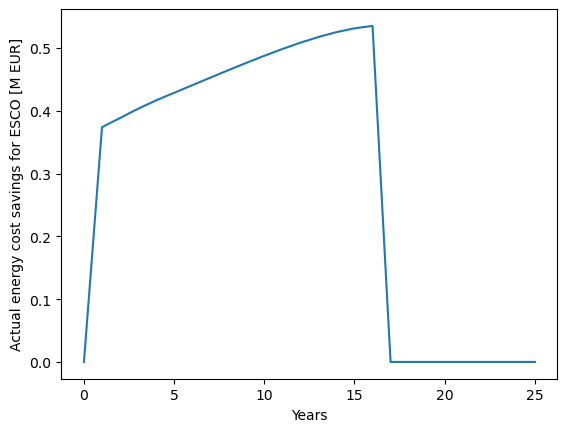

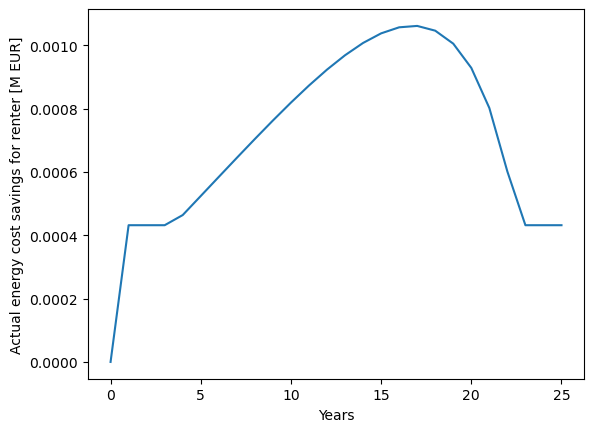

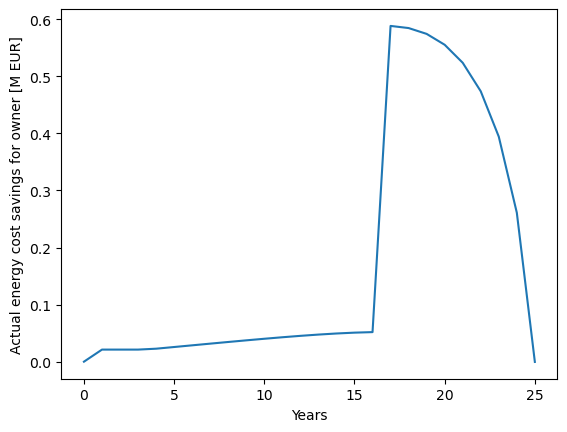

Optimal share theta 16 = 0.73
Optimal NPV O 16 = 4.0250582245095865


In [8]:
# Simulate a contract duration of 16 years
params['n'] = 16
NPVR_16, NPV0_16, NPVE_16, NPVP, R, R_E, R_R, R_O, PE, f, Re, K, Q, R, vec_Re_16, thetas, theta_opt_16 = simulation(params, theta_min, theta_max, N)

plt.plot(t, R_E/1e6)
plt.xlabel('Years')
plt.ylabel('Actual energy cost savings for ESCO [M EUR]')
plt.show()

plt.plot(t, R_R/1e6)
plt.xlabel('Years')
plt.ylabel('Actual energy cost savings for renter [M EUR]')
plt.show()

plt.plot(t, R_O/1e6)
plt.xlabel('Years')
plt.ylabel('Actual energy cost savings for owner [M EUR]')
plt.show()

print("Optimal share theta 16 =", theta_opt_16)
print("Optimal NPV O 16 =", max(NPV0_16))

In [9]:
params['n'] = 17
NPVR_17, NPV0_17, NPVE_17, NPVP, R, R_E, R_R, R_O, PE, f, Re, K, Q, R, vec_Re_17, thetas, theta_opt_17 = simulation(params, theta_min, theta_max, N)
print("Optimal share theta 17 =", theta_opt_17)
print("Optimal NPV O 17 =", max(NPV0_17))

params['n'] = 18
NPVR_18, NPV0_18, NPVE_18, NPVP, R, R_E, R_R, R_O, PE, f, Re, K, Q, R, vec_Re_18, thetas, theta_opt_18 = simulation(params, theta_min, theta_max, N)
print("Optimal share theta 18 =", theta_opt_18)
print("Optimal NPV O 18 =", max(NPV0_18))

params['n'] = 19
NPVR_19, NPV0_19, NPVE_19, NPVP, R, R_E, R_R, R_O, PE, f, Re, K, Q, R, vec_Re_19, thetas, theta_opt_19 = simulation(params, theta_min, theta_max, N)
print("Optimal share theta 19 =", theta_opt_19)
print("Optimal NPV O 19 =", max(NPV0_19))

Optimal share theta 17 = 0.74
Optimal NPV O 17 = 3.526802832091098
Optimal share theta 18 = 0.75
Optimal NPV O 18 = 3.0479087943535297
Optimal share theta 19 = 0.76
Optimal NPV O 19 = 2.5926117798354857


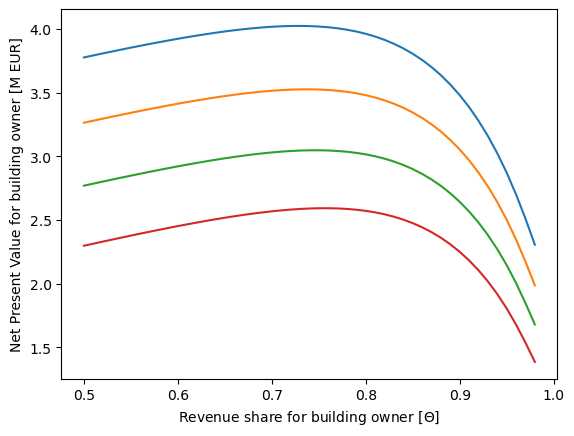

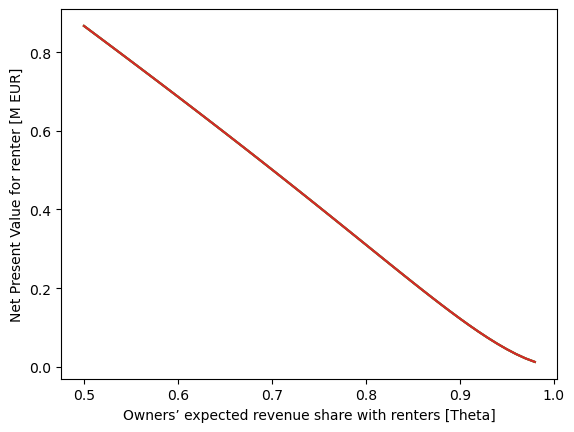

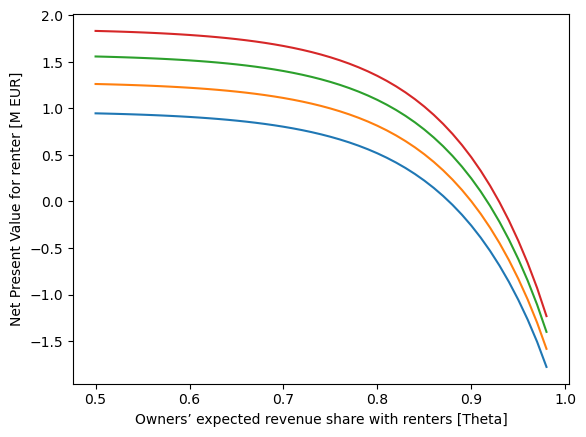

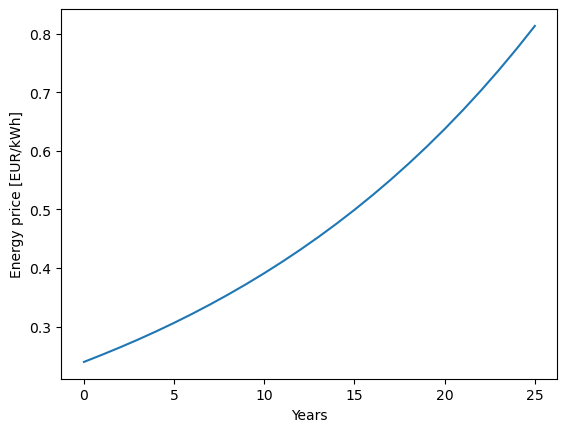

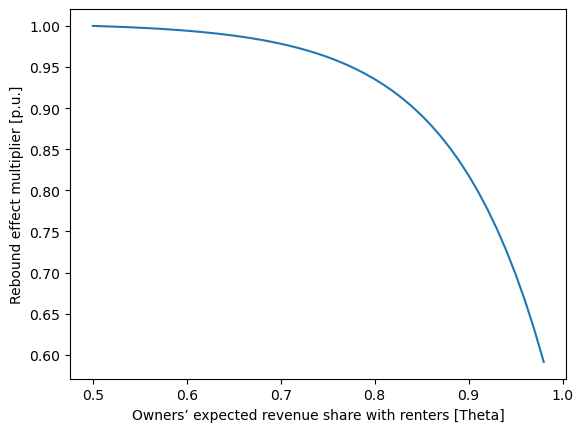

In [10]:
plt.plot(thetas, NPV0_16)
plt.plot(thetas, NPV0_17)
plt.plot(thetas, NPV0_18)
plt.plot(thetas, NPV0_19)
plt.xlabel('Revenue share for building owner [$\Theta$]')
plt.ylabel('Net Present Value for building owner [M EUR]')
plt.show()

plt.plot(thetas, NPVR_16)
plt.plot(thetas, NPVR_17)
plt.plot(thetas, NPVR_18)
plt.plot(thetas, NPVR_19)
plt.xlabel('Owners’ expected revenue share with renters [Theta]')
plt.ylabel('Net Present Value for renter [M EUR]')
plt.show()

plt.plot(thetas, NPVE_16)
plt.plot(thetas, NPVE_17)
plt.plot(thetas, NPVE_18)
plt.plot(thetas, NPVE_19)
plt.xlabel('Owners’ expected revenue share with renters [Theta]')
plt.ylabel('Net Present Value for renter [M EUR]')
plt.show()

t = np.arange(26)
plt.plot(t, PE)
plt.xlabel('Years')
plt.ylabel('Energy price [EUR/kWh]')
plt.show()

plt.plot(thetas, vec_Re_16)
plt.xlabel('Owners’ expected revenue share with renters [Theta]')
plt.ylabel('Rebound effect multiplier [p.u.]')
plt.show()